# Re-gridding zecmip

The aim of this notebook is to re-grid all of the zecmip data to a common grid.


In [1]:
import xarray as xr
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import warnings
import xesmf 
import cftime
warnings.filterwarnings('ignore')
from typing import NamedTuple
sys.path.append('modules')
from typing import NamedTuple, List
from functools import partial
import constants
import xarray_class_accessors as xca
import sn_plotting
import climtas
from typing import Callable
import open_ds
import json

In [2]:
from multiprocessing import Pool

In [3]:
# File that contains all the saved paths for zecmip runs
with open('data/zecmip_model_paths.json', 'r') as f:
    zecmip_model_paths = json.loads(f.read())

In [4]:
pprint(zecmip_model_paths)

{'1000pgc': {'all': ['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/pr/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/pr/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/tas/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r3i1p2f1/Amon/pr/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r3i1p2f1/Amon/tas/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r4i1p2f1/Amon/pr/gn/v20190429',
                     '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r4i1p2f1/Amon/tas/gn/v20190429',
    

In [5]:
zecmip_model_paths.keys()

dict_keys(['1000pgc', 'picontrol'])

In [6]:
zecmip_model_paths['1000pgc'].keys()

dict_keys(['all', 'needed'])

In [7]:
needed_experiments = list(zecmip_model_paths['1000pgc']['needed'].values())
needed_experiments

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108',
 '/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701']

# Functions

In [8]:
def open_and_rename(fname, open_func):
    '''Open the file, then add the model dimension'''
    ds = open_func(fname)
    
    model = fname.split('/')[8]
    print(model)
    ds = ds.expand_dims('model').assign_coords(model=('model', [model]))

    return ds

In [19]:
def standardise_ds(ds: xr.Dataset)->xr.Dataset:
    '''
    Function that is a collection of functions.
    Function will
        * refactor dimensions (latitude -> lat ect.)
        * Add model dim
        * Change time to start from 0.
    '''

    print(f'\n{ds.model.values}')
    # Make sure dims have correct names
    ds = open_ds.refactor_dims(ds)
    
    
    print('Removing uneeded coordinates')
    
    ds = ds.drop(['bnds', 'height', 'bounds', 'lev', 'level'], errors='ignore')[['tas']]

    # Time should all be the same
    ds = ds.resample(time='Y').mean()
    print('Resample to yearly frequency')
    ds['time'] = open_ds.make_new_time(ds, freq='1Y')
    
    return ds

In [32]:
def save_file(ds: xr.Dataset, directory:str):
    model = str(ds.model.values[0])
    save_name = os.path.join(directory, model+ '.nc')
    print(save_name)
    ds.to_netcdf(save_name)

The following code uses partial functions to reduce code being re-used

## Experiment

In [44]:
needed_experiments_wild_card = [os.path.join(fname, '*.nc') for fname in needed_experiments]
needed_experiments_wild_card[:3]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210/*.nc']

In [10]:
# Opening

open_mfdataset_cf_time = partial(xr.open_mfdataset, use_cftime=True)
open_and_rename_experiment = partial(open_and_rename, open_func = open_mfdataset_cf_time)

%%time
# Opening all the needed experiments with the open_and_raname function. This function
# takes an function as an arguement on how to open the dataset. For this a xr.open_mfdataset
# with use_cftime=True filled.
with Pool() as pool:
    experiment_ds_raw_list = pool.map(open_and_rename_experiment, needed_experiments_wild_card)

In [12]:
len(experiment_ds_raw_list)

8

In [20]:
# Standardising

%%time
with Pool() as pool:
    experiment_ds_list = pool.map(standardise_ds, experiment_ds_raw_list) 


['CanESM5']
Removing uneeded coordinates

['MIROC-ES2L']

['UKESM1-0-LL']
['MPI-ESM1-2-LR']
Removing uneeded coordinates
['GISS-E2-1-G-CC']

Removing uneeded coordinatesRemoving uneeded coordinates

['CESM2']

Removing uneeded coordinates

['NorESM2-LM']

['GFDL-ESM4']Removing uneeded coordinates


Removing uneeded coordinates
Removing uneeded coordinates
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 185
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 180
Resample to yearly frequency
Chaning

## Pi-control

In [43]:
needed_experiments[:3]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210']

In [15]:
# Partial filled open_ds.zecmip_open_matching_picontrol function.
open_func = partial(open_ds.zecmip_open_matching_picontrol, 
                    unique_picontrol_paths = zecmip_model_paths['picontrol'])
open_and_rename_picontrol = partial(open_and_rename, open_func = open_func)

In [17]:
%%time
with Pool() as pool:
    picontrol_ds_raw_list = pool.map(open_and_rename_picontrol, needed_experiments)

Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000Pg

In [21]:
%%time
with Pool() as pool:
    picontrol_ds_list = pool.map(standardise_ds, picontrol_ds_raw_list)


['MIROC-ES2L']
Removing uneeded coordinates

['CanESM5']
Removing uneeded coordinates

['UKESM1-0-LL']
Removing uneeded coordinates

['GISS-E2-1-G-CC']
Removing uneeded coordinates

['MPI-ESM1-2-LR']
Removing uneeded coordinates

['CESM2']
Removing uneeded coordinates

['NorESM2-LM']
Removing uneeded coordinates

['GFDL-ESM4']
Removing uneeded coordinates
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 165
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
Resample to yearly frequency
Resample to yearly frequencyChaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 501

Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 750
Resample to yearly frequency
Chaning

# Verificaiton
Verifying the time, values and grids are all correct.

## Grid Analysis

In [22]:
class ModelGrid(NamedTuple):
    model: str
    lat: float
    lon: float
    no_points: float = None

In [23]:
model_grids = []
for ds in picontrol_ds_raw_list:
    model = str(ds.model.values)
    lat_grid = np.mean(np.unique(np.round(np.diff(ds.lat.values),3)))
    lon_grid = np.mean(np.unique(np.round(np.diff(ds.lon.values),3)))
    
    model_grids.append(ModelGrid(model, lat=lat_grid, lon=lon_grid))

In [24]:
model_grids

[ModelGrid(model="['CanESM5']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['MIROC-ES2L']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['UKESM1-0-LL']", lat=1.25, lon=1.875, no_points=None),
 ModelGrid(model="['MPI-ESM1-2-LR']", lat=1.8605999999999998, lon=1.875, no_points=None),
 ModelGrid(model="['GISS-E2-1-G-CC']", lat=2.0, lon=2.5, no_points=None),
 ModelGrid(model="['CESM2']", lat=0.942, lon=1.25, no_points=None),
 ModelGrid(model="['NorESM2-LM']", lat=1.895, lon=2.5, no_points=None),
 ModelGrid(model="['GFDL-ESM4']", lat=1.0, lon=1.25, no_points=None)]

Testing to make sure all the values match!

## Data is not bugged

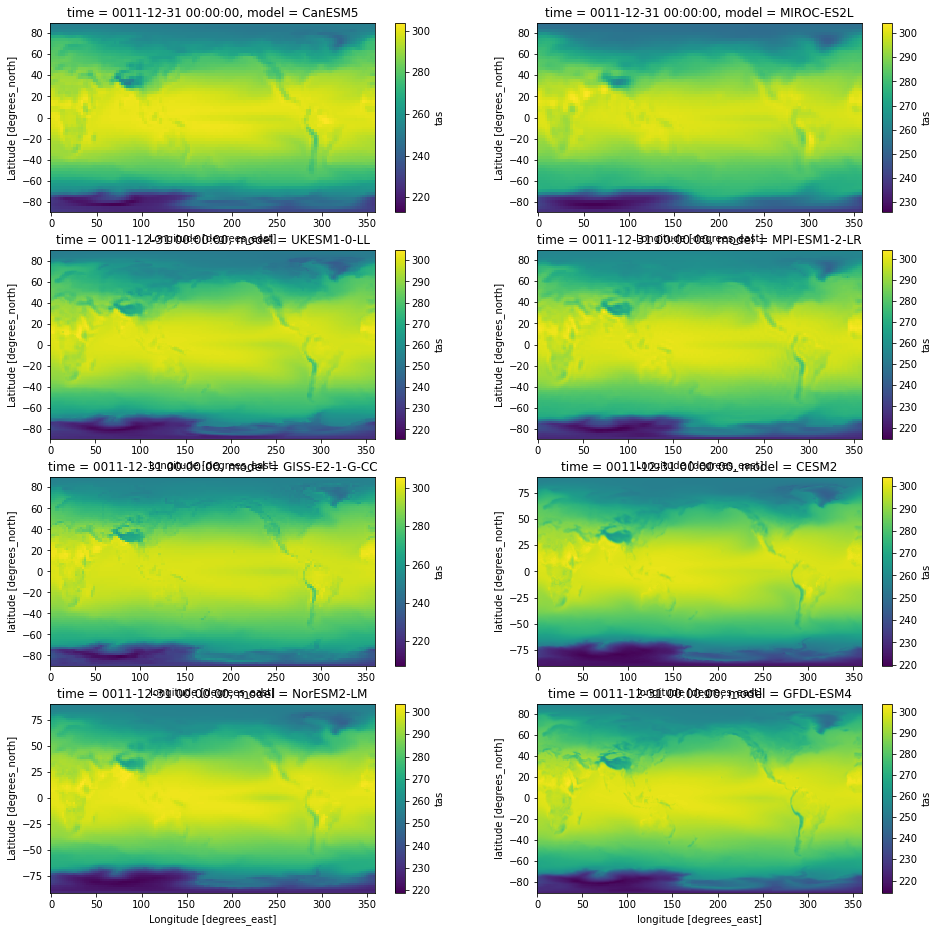

In [25]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.isel(time=10).plot(ax=ax)

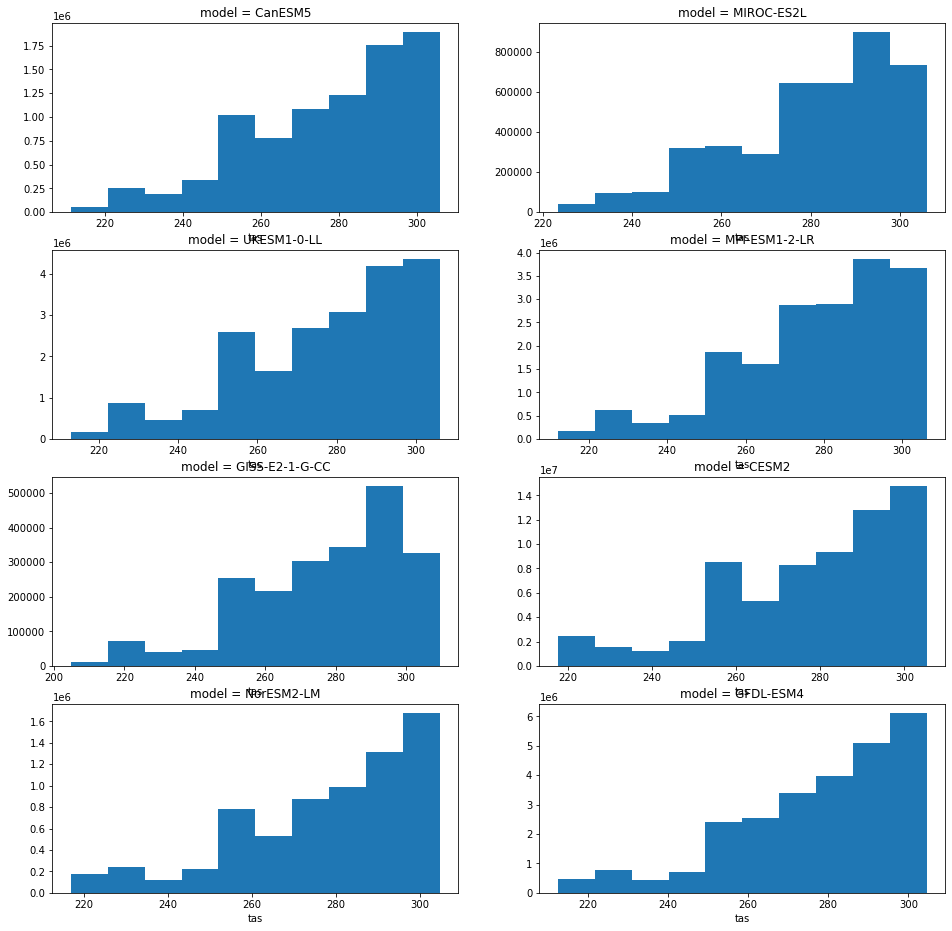

In [26]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.plot(ax=ax)

In [40]:
# The frequency is about one month for all the models
for ds in picontrol_ds_raw_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 30 days, 0:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00


In [41]:
# The time should now be yearly.
for ds in picontrol_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00


In [13]:
# The frequency is about one month for all the models
for ds in experiment_ds_raw_list:
    time_diff = np.diff(experiment_ds_raw_list[0].time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 29 days, 12:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00


In [28]:
# The time should now be yearly.
for ds in experiment_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00


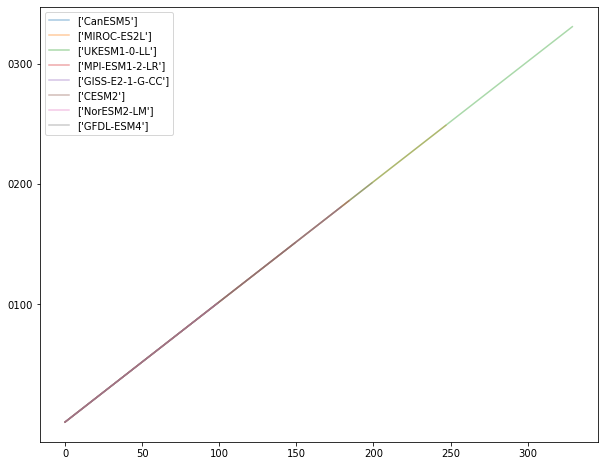

In [29]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for ds in experiment_ds_list:
    ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)
ax.legend(loc='best')

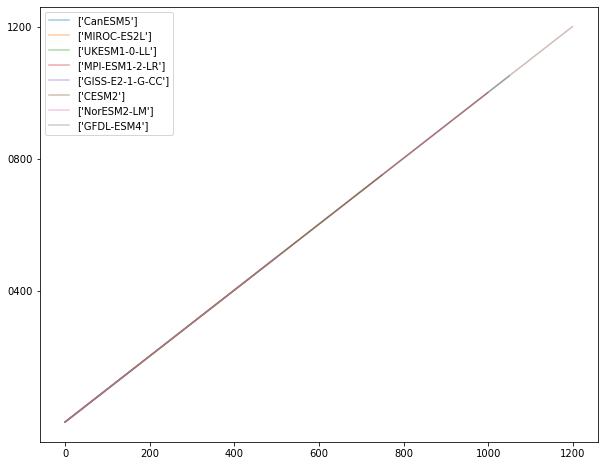

In [30]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for ds in picontrol_ds_list:
    ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)    
ax.legend(loc='best')

# Saving Files

In [31]:
constants.ZECMIP_LOCAL_DIR

'/g/data/w40/ab2313/PhD/zecmip'

In [39]:
experiment_save_path = os.path.join(constants.ZECMIP_LOCAL_DIR, 'original', '4xCO2')
experiment_save_path

'/g/data/w40/ab2313/PhD/zecmip/original/4xCO2'

In [33]:
[save_file(ds, directory = experiment_save_path) for ds in experiment_ds_list]

/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/CanESM5.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/MIROC-ES2L.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/UKESM1-0-LL.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/MPI-ESM1-2-LR.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/GISS-E2-1-G-CC.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/CESM2.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/NorESM2-LM.nc
/g/data/w40/ab2313/PhD/zecmip/original/4xCO2/GFDL-ESM4.nc


[None, None, None, None, None, None, None, None]

In [37]:
picontrol_save_path = os.path.join(constants.ZECMIP_LOCAL_DIR, 'original', 'picontrol')
picontrol_save_path

'/g/data/w40/ab2313/PhD/zecmip/original/picontrol'

In [38]:
(save_file(ds, directory = picontrol_save_path) for ds in picontrol_ds_list)

/g/data/w40/ab2313/PhD/zecmip/original/picontrol/CanESM5.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/MIROC-ES2L.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/UKESM1-0-LL.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/MPI-ESM1-2-LR.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/GISS-E2-1-G-CC.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/CESM2.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/NorESM2-LM.nc
/g/data/w40/ab2313/PhD/zecmip/original/picontrol/GFDL-ESM4.nc


[None, None, None, None, None, None, None, None]